# Laboratorio 02

In [115]:
import numpy as np
import skimage as sk
from matplotlib import pyplot as plt
import cv2 as cv

In [116]:
image_name = "person.png"

In [117]:
image = cv.imread(f'images/{image_name}', cv.IMREAD_GRAYSCALE)
# Convert to numpy array
image = np.array(image) / 255.0

## Inciso 1

In [118]:
def resize_image(image, k = 1):
		# (128k, 64k) is the new size of the image
		new_size = (int(128 * k), int(64 * k))
		# Resize the image
		image = sk.transform.resize(image, new_size, anti_aliasing=True)
		return image



In [119]:
resized_image = resize_image(image, 1)


## Inciso 2

In [120]:
from scipy.ndimage import convolve

def prewitt_operator(grayscale_image):
    # Kernels Perwitt
    Gx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    Gy = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    
    # Compute the gradient in the x and y directions
    grad_x = convolve(grayscale_image, Gx)
    grad_y = convolve(grayscale_image, Gy)
    
    # Compute the gradient magnitude
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    # Compute the gradient direction (angle)
    angle = np.arctan2(-grad_y, grad_x) * (180 / np.pi)
    # Ensure the angle is within 0 to 180 degrees
    angle[angle < 0] += 180
    angle = angle % 180
    
    return magnitude, angle

In [121]:
magnitude, angle = prewitt_operator(resized_image)


In [122]:
def generate_magnitude_and_angle_for_image(image_name, k=1):
		image = cv.imread(f'images/{image_name}', cv.IMREAD_GRAYSCALE)
		# Convert to numpy array
		image = np.array(image) / 255.0
		resized_image = resize_image(image, k)
		magnitude, angle = prewitt_operator(resized_image)
		return magnitude, angle


In [123]:
k = 1
magnitude, angle = generate_magnitude_and_angle_for_image(image_name, k)

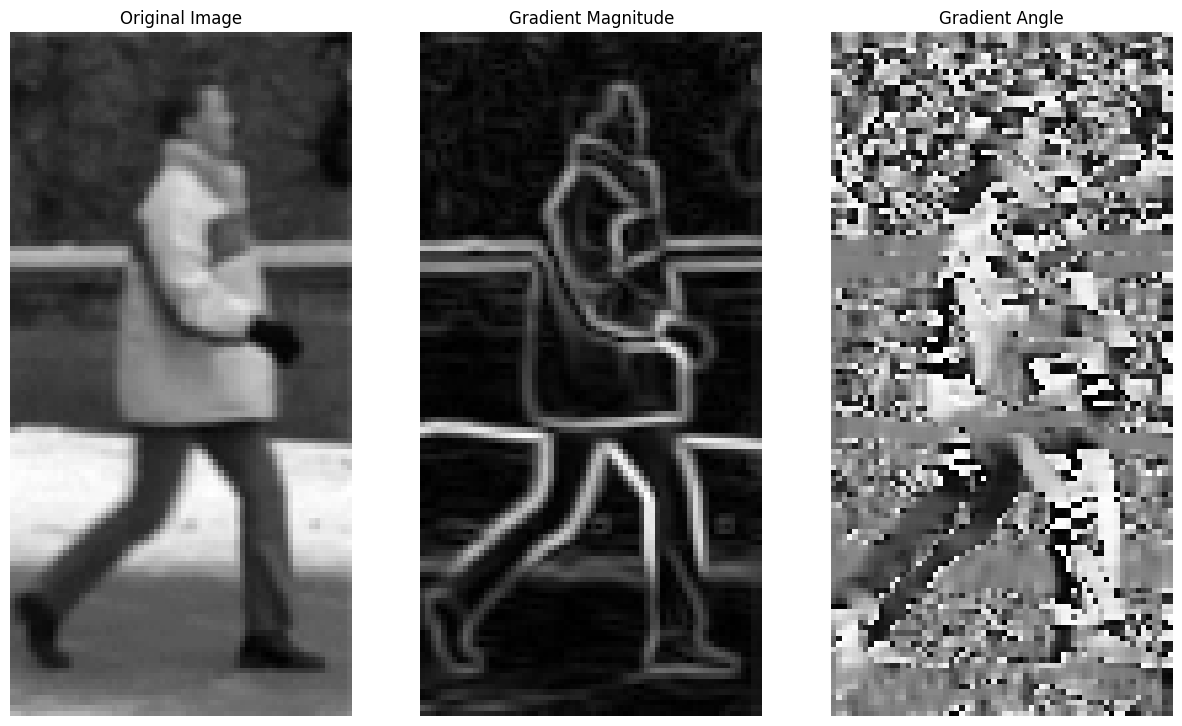

In [124]:
# Create a figure to display the results
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
ax = axes.ravel()
ax[0].imshow(resized_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(magnitude, cmap='gray')
ax[1].set_title('Gradient Magnitude')
ax[1].axis('off')
ax[2].imshow(angle, cmap='gray')
ax[2].set_title('Gradient Angle')
ax[2].axis('off')
plt.axis('off')
plt.show()

In [125]:

def get_block(area, row_step, col_step, block_size): return area[row_step : row_step + block_size, col_step : col_step + block_size]

def gen_blocks_stacks(magnitude, angle, block_size):
    
    WIDTH, HEIGHT = magnitude.shape
    STRIDE = block_size // 2
    M = int((WIDTH / STRIDE) - 1)
    N = int((HEIGHT / STRIDE) - 1)

    blocks_magnitude = np.zeros((M, N, block_size, block_size))
    blocks_angle = np.zeros((M, N, block_size, block_size))


    for i in range(M):
        for j in range(N):
            row_step = i * STRIDE
            col_step = j * STRIDE

            blocks_magnitude[i, j] = get_block(magnitude, row_step, col_step, block_size)
            blocks_angle[i, j] = get_block(angle, row_step, col_step, block_size)

            
    return blocks_magnitude, blocks_angle

block_size = 8
blocks_magnitude, blocks_angle = gen_blocks_stacks(magnitude, angle, block_size)

In [126]:
blocks_magnitude.shape

(31, 15, 8, 8)

In [127]:
def build_histograms(m_bstack, a_bstack, n_bins):
    M, N, block_size, _ = m_bstack.shape
    histograms = np.zeros((M, N, n_bins))
    bin_centers = np.linspace(0, 180, n_bins, endpoint=False)

    for i in range(M):
        for j in range(N):
            m_block = m_bstack[i, j]
            a_block = a_bstack[i, j]
            histogram = np.zeros(n_bins)

            for k in range(block_size):
                for l in range(block_size):
                    angle = a_block[k, l]
                    magnitude = m_block[k, l]
                    
                    new_magnitude = None
                    angle_diff = np.abs(angle - bin_centers)
                    for idx, _ in enumerate(angle_diff):
                        if idx < len(angle_diff) - 1 and angle_diff[idx] == angle_diff[idx + 1]:
                            new_magnitude = magnitude / 2
                            histogram[idx] += new_magnitude
                            histogram[idx + 1] += new_magnitude
                            break
                    
                    if new_magnitude == None:
                        idx = np.argmin(angle_diff)
                        histogram[idx] += magnitude

            histogram = histogram / np.linalg.norm(histogram)
            histograms[i, j] = histogram            

    return histograms

n_bins = 9
histograms = build_histograms(blocks_magnitude, blocks_angle, n_bins)

In [128]:
histograms.shape

(31, 15, 9)

In [129]:
histograms

array([[[0.14965991, 0.2491304 , 0.29525959, ..., 0.39891057,
         0.12494931, 0.15219897],
        [0.16342392, 0.21677467, 0.32738658, ..., 0.11025047,
         0.20148842, 0.23339005],
        [0.06158082, 0.05230044, 0.25366575, ..., 0.21061829,
         0.4132686 , 0.24207809],
        ...,
        [0.00672528, 0.12846055, 0.30881449, ..., 0.14026831,
         0.02434126, 0.14030613],
        [0.11241198, 0.23153225, 0.61818965, ..., 0.00794868,
         0.06694155, 0.31146119],
        [0.15206821, 0.25471643, 0.68478362, ..., 0.0695317 ,
         0.15786285, 0.36436167]],

       [[0.22875736, 0.42352322, 0.3772249 , ..., 0.51415616,
         0.14403123, 0.14841985],
        [0.33564939, 0.59579709, 0.42638168, ..., 0.17165911,
         0.22067211, 0.37123804],
        [0.21041891, 0.26149882, 0.27671853, ..., 0.33061683,
         0.44595558, 0.58710662],
        ...,
        [0.01621572, 0.2127331 , 0.13179973, ..., 0.46258533,
         0.45939184, 0.33655148],
        [0.2